# FISTA vs. Newton 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.fista_newton import *

In [3]:
def plot_fista_newton(bench_out, filename=None):
    ps = bench_out['ps']
    index_names = bench_out['index_names']
    times = bench_out['times']
    accs = bench_out['accs']

    markers = ['.', '*', 'v', 'x', '1', '2']
    linestyles = ['-.'] * len(markers)
    
    types = [times, accs]
    type_names = ["Time", "Accuracy"]
    ylabels = ["Time (s)", "$\max_i |\hat{\\beta}_i - \\beta^{\star}_i |$"]

    fig, axes = plt.subplots(1, 2, figsize=(8,6), layout='compressed')
    for j in range(2):
        ax = axes[j]
        vals = types[j]
        for i, vals_alg in enumerate(vals):
            ax.plot(ps, vals_alg, marker=markers[i], label=index_names[i], linestyle=linestyles[i])
        ax.legend()
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_title(f"{type_names[j]} Comparison")
        ax.set_xlabel("Number of features ($p$)")
        ax.set_ylabel(ylabels[j])
                
    bench_out['plot'] = fig

    if not (filename is None):
        plt.savefig(f"figures/pgd_newton_{filename}.pdf", bbox_inches='tight')
    plt.show()

    return bench_out

In [4]:
ps = np.array([10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 750, 1000, 2500, 5000, 7500, 10000])

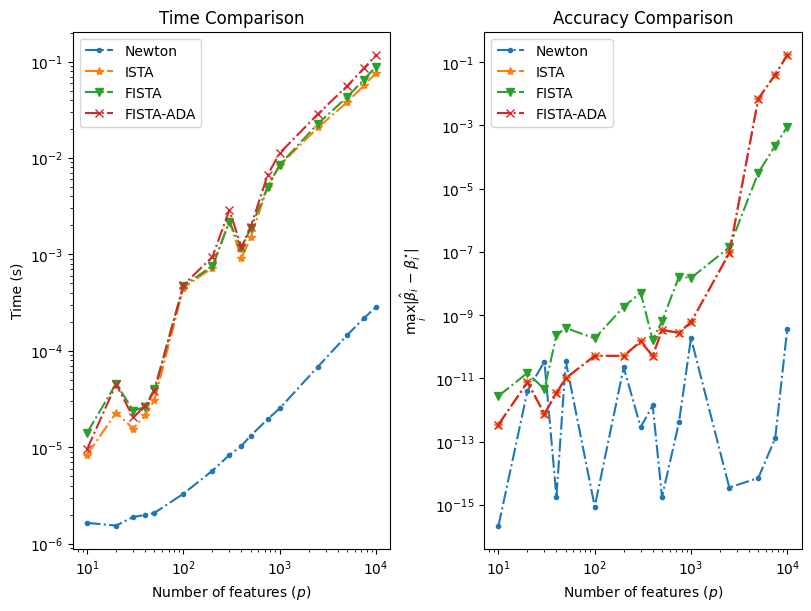

In [5]:
configs = {
    'seed': 69, 
    'min_eval': 0,
    'max_eval': 1, 
    'l1': 1e-1, 
    "l2": 0, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.0,
    'newton_times': 1000,
    'fista_times': 10,
    'skip': ['Newton-ABS', 'Newton-Brent', 'Brent'],
}
bench_fista_newton = plot_fista_newton(bench(ps, configs), filename='fista_newton')

## Newton Methods

In [29]:
def plot_newton(bench_out, ax, title):
    ps = bench_out['ps']
    index_names = bench_out['index_names']
    times = bench_out['times']

    markers = ['.', '*', 'v', 'x', '1', '2']
    linestyles = ['-.'] * len(markers)
    
    for i, vals_alg in enumerate(times):
        ax.plot(ps, vals_alg, marker=markers[i], label=index_names[i], linestyle=linestyles[i])
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
                
    bench_out['plot'] = ax

    return bench_out

In [22]:
configs = {
    'seed': 69, 
    'min_eval': 0,
    'max_eval': 1, 
    'l1': 1e-1, 
    "l2": 0, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.0,
    'newton_times': 3000,
    'fista_times': 0,
    'skip': ['ISTA', 'FISTA', 'FISTA-ADA', 'Newton-Brent'],
}
bench_pd = bench(ps, configs)

In [23]:
configs = {
    'seed': 69, 
    'min_eval': 0,
    'max_eval': 1, 
    'l1': 1e-1, 
    "l2": 0, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.01,
    'newton_times': 3000,
    'fista_times': 0,
    'skip': ['ISTA', 'FISTA', 'FISTA-ADA', 'Newton-Brent'],
}
bench_almost_psd = bench(ps, configs)

In [24]:
configs = {
    'seed': 69, 
    'min_eval': 0,
    'max_eval': 1, 
    'l1': 1e-1, 
    "l2": 0, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.2,
    'L_small_prop': 0.1,
    'newton_times': 3000,
    'fista_times': 0,
    'skip': ['ISTA', 'FISTA', 'FISTA-ADA', 'Newton-Brent'],
}
bench_very_psd = bench(ps, configs)

In [25]:
configs = {
    'seed': 69, 
    'min_eval': 0,
    'max_eval': 1, 
    'l1': 1e-4, 
    "l2": 0, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.,
    'L_small_prop': 0.,
    'newton_times': 3000,
    'fista_times': 0,
    'skip': ['ISTA', 'FISTA', 'FISTA-ADA', 'Newton-Brent'],
}
bench_low_regul = bench(ps, configs)

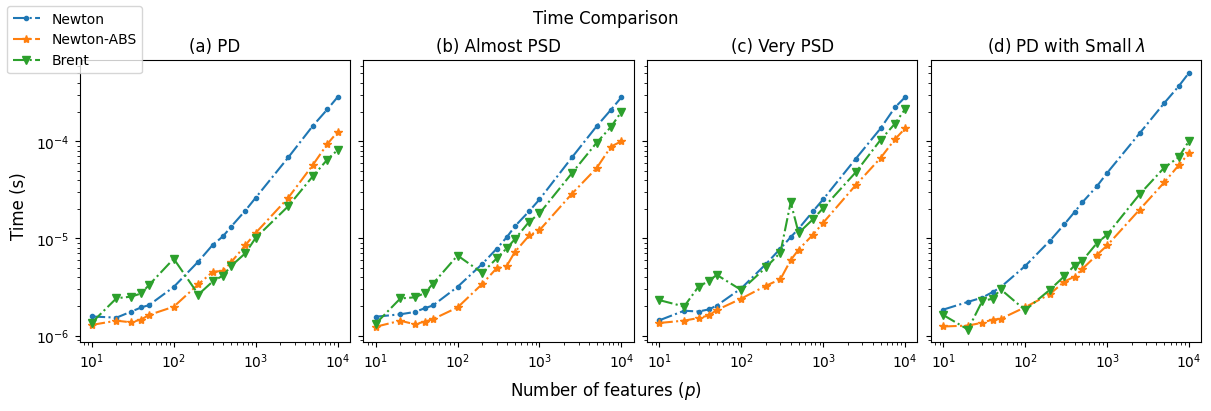

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(12,4), sharey=True, layout='compressed')
plot_newton(bench_pd, axes[0], '(a) PD')
plot_newton(bench_almost_psd, axes[1], '(b) Almost PSD')
plot_newton(bench_very_psd, axes[2], '(c) Very PSD')
plot_newton(bench_low_regul, axes[3], '(d) PD with Small $\lambda$')
fig.suptitle("Time Comparison")
fig.supxlabel("Number of features ($p$)")
fig.supylabel("Time (s)")
fig.legend(labels=bench_pd['index_names'], loc='upper left')
plt.savefig("figures/newton_compare.pdf", bbox_inches='tight')
plt.show()

In [31]:
(
(
    np.sort(bench_pd['times'][2] / bench_pd['times'][1])[[0, -1]],
    np.sort(bench_almost_psd['times'][2] / bench_almost_psd['times'][1])[[0, -1]],
    np.sort(bench_very_psd['times'][2] / bench_very_psd['times'][1])[[0, -1]],
    np.sort(bench_low_regul['times'][2] / bench_low_regul['times'][1])[[0, -1]],
),
(
    np.sort(bench_pd['times'][0] / bench_pd['times'][1])[[0, -1]],
    np.sort(bench_almost_psd['times'][0] / bench_almost_psd['times'][1])[[0, -1]],
    np.sort(bench_very_psd['times'][0] / bench_very_psd['times'][1])[[0, -1]],
    np.sort(bench_low_regul['times'][0] / bench_low_regul['times'][1])[[0, -1]],
)
)

((array([0.65092545, 3.12012436]),
  array([1.07430843, 3.42776334]),
  array([1.22207354, 3.94728025]),
  array([0.91124159, 2.02351654])),
 (array([1.07495658, 2.60289679]),
  array([1.16485671, 2.83552089]),
  array([1.0665056 , 2.12514577]),
  array([1.49243718, 6.70366767])))

## Debug Section